In [1]:
!unzip data.zip

Archive:  data.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [2]:
# ## 1. Setup and Imports
# 필요한 라이브러리를 모두 불러옵니다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# NLTK 불용어 다운로드 (최초 1회만 필요)
try:
    stopwords.words('english')
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords')
    print("Download complete.")

Download complete.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# ## 2. Hyperparameters and Configuration
VOCAB_SIZE = 20000  # 어휘 사전의 최대 크기
MAX_LEN = 200       # 시퀀스의 최대 길이
EMBEDDING_DIM = 128 # 임베딩 벡터의 차원
BATCH_SIZE = 64
EPOCHS = 10         # EarlyStopping을 사용하므로 최대 Epoch 설정

In [4]:
# ## 3. Data Loading and Merging
# Fake.csv와 True.csv 파일을 로드하고 하나의 데이터프레임으로 결합합니다.
try:
    df_fake = pd.read_csv("Fake.csv")
    df_true = pd.read_csv("True.csv")

    df_fake["class"] = 0  # 가짜 뉴스: 0
    df_true["class"] = 1   # 진짜 뉴스: 1

    # 두 데이터프레임을 하나로 합치고 샘플 순서를 섞습니다.
    df_merged = pd.concat([df_fake, df_true], ignore_index=True)
    df_merged = df_merged.sample(frac=1, random_state=42).reset_index(drop=True)

    print("Data loading and merging complete.")
    print(f"Total articles: {len(df_merged)}")

except FileNotFoundError:
    print("Error: Fake.csv or True.csv not found. Please check file paths.")
    df_merged = pd.DataFrame()


Data loading and merging complete.
Total articles: 44898


In [5]:
# ## 4. Exploratory Data Analysis (EDA)
# 제목과 텍스트를 합치기 전 원본 데이터 확인
print("\nSample of merged data:")
print(df_merged.head())


Sample of merged data:
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  class  
0    February 13, 2017      0  
1       April 5, 2017       1  
2  September 27, 2017       1  
3         May 22, 2017      0  
4       June 24, 2016       1  


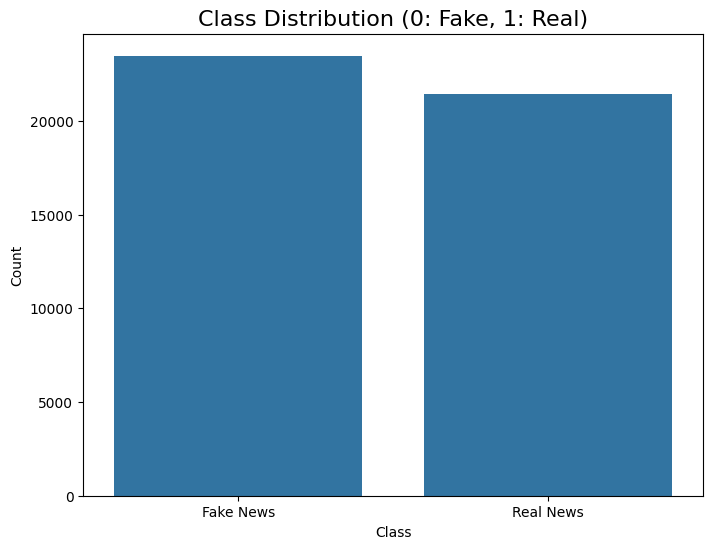

In [6]:
# 클래스 분포 시각화
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df_merged)
plt.title('Class Distribution (0: Fake, 1: Real)', fontsize=16)
plt.xticks([0, 1], ['Fake News', 'Real News'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

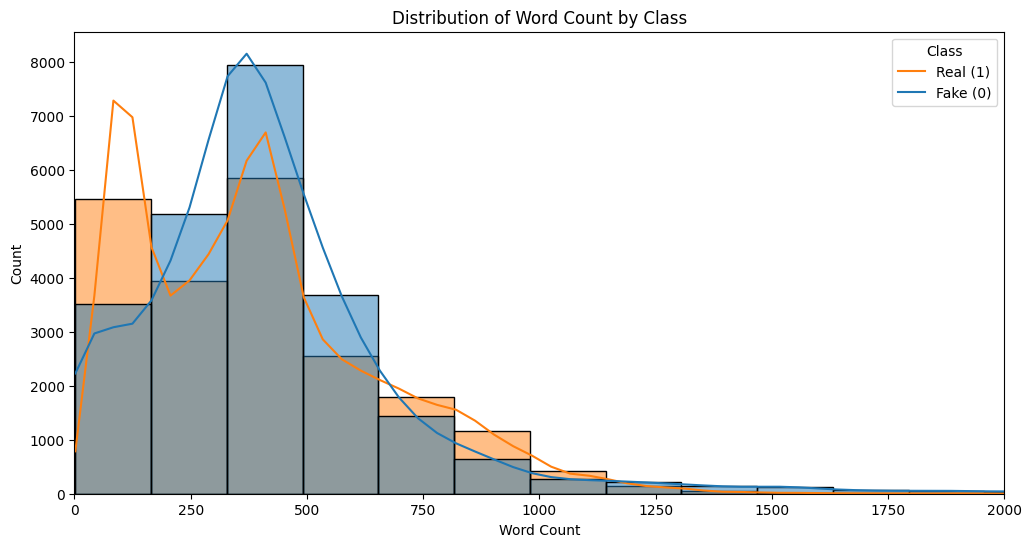

In [7]:
# 제목(title)과 본문(text)을 하나의 'text' 컬럼으로 결합
df_merged['text'] = df_merged['title'] + " " + df_merged['text']
df_merged = df_merged.drop(['title', 'subject', 'date'], axis=1)

# 텍스트 길이 분포 시각화
df_merged['word_count'] = df_merged['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.histplot(data=df_merged, x='word_count', hue='class', kde=True, bins=50)
plt.title('Distribution of Word Count by Class')
plt.xlim(0, 2000) # 길이 범위를 제한하여 가독성 높임
plt.xlabel('Word Count')
plt.legend(title='Class', labels=['Real (1)', 'Fake (0)'])
plt.show()

In [8]:
# ## 5. Text Preprocessing
# 텍스트 데이터를 정제하고 모델이 학습할 수 있는 숫자 시퀀스로 변환합니다.
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """텍스트 클리닝 함수: 소문자화, 불용어/특수문자/URL 등 제거"""
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # 불용어 제거
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

<>:8: SyntaxWarning: invalid escape sequence '\['
<>:9: SyntaxWarning: invalid escape sequence '\S'
<>:13: SyntaxWarning: invalid escape sequence '\w'
<>:8: SyntaxWarning: invalid escape sequence '\['
<>:9: SyntaxWarning: invalid escape sequence '\S'
<>:13: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-1094424585.py:8: SyntaxWarning: invalid escape sequence '\['
  text = re.sub('\[.*?\]', '', text)
/tmp/ipython-input-1094424585.py:9: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('https?://\S+|www\.\S+', '', text)
/tmp/ipython-input-1094424585.py:13: SyntaxWarning: invalid escape sequence '\w'
  text = re.sub('\w*\d\w*', '', text)



Cleaning text data...
Text cleaning complete.


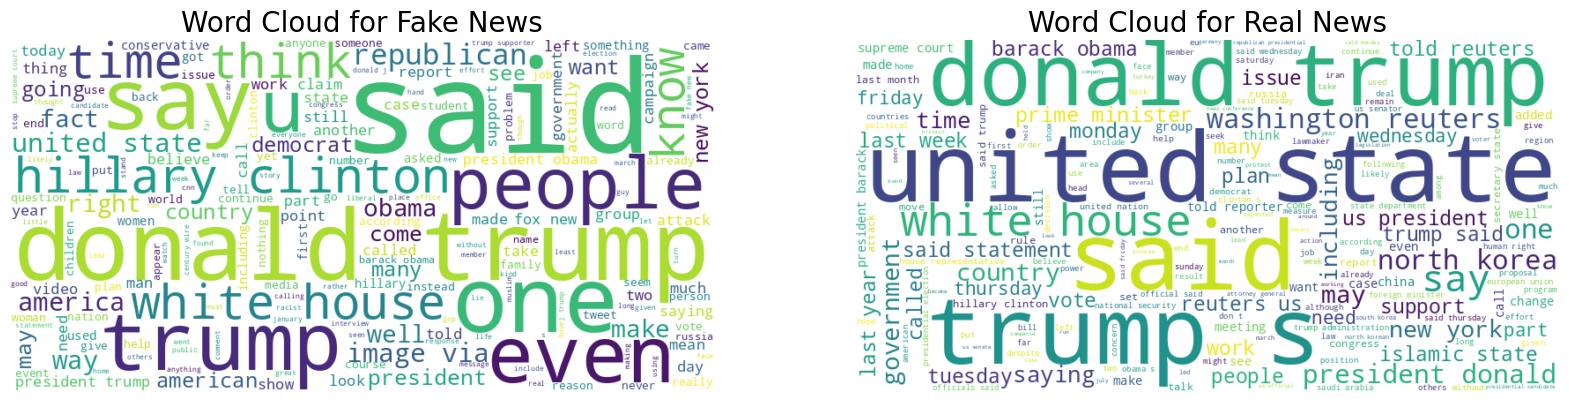

In [9]:
if not df_merged.empty:
    # 텍스트 클리닝 적용
    print("\nCleaning text data...")
    df_merged['text'] = df_merged['text'].apply(clean_text)
    print("Text cleaning complete.")

    # 워드클라우드 시각화
    plt.figure(figsize=(20, 10))
    # Fake News
    fake_text = " ".join(df_merged[df_merged['class'] == 0]['text'])
    wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_fake, interpolation='bilinear')
    plt.title('Word Cloud for Fake News', fontsize=20)
    plt.axis('off')
    # Real News
    real_text = " ".join(df_merged[df_merged['class'] == 1]['text'])
    wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)
    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_real, interpolation='bilinear')
    plt.title('Word Cloud for Real News', fontsize=20)
    plt.axis('off')
    plt.show()

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        df_merged['text'],
        df_merged['class'],
        test_size=0.2,
        random_state=42
    )

    # 토큰화 및 시퀀스 변환
    tokenizer = Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # 패딩
    X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
    X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [10]:
# ## 6. Model Building & Training
if not df_merged.empty:
    # LSTM 모델 구성
    model = Sequential([
        Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
        LSTM(128),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') # 이진 분류를 위한 sigmoid 활성화 함수
    ])

    # 모델 컴파일
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    model.summary()

    # EarlyStopping 콜백 설정
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    # 모델 학습
    history = model.fit(
        X_train_pad, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test_pad, y_test),
        callbacks=[early_stopping]
    )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 262s 459ms/step - accuracy: 0.9212 - loss: 0.2091 - val_accuracy: 0.9783 - val_loss: 0.0620
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 260s 456ms/step - accuracy: 0.9826 - loss: 0.0558 - val_accuracy: 0.9885 - val_loss: 0.0379
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 263s 457ms/step - accuracy: 0.9950 - loss: 0.0162 - val_accuracy: 0.9866 - val_loss: 0.0502
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 261s 456ms/step - accuracy: 0.9971 - loss: 0.0094 - val_accuracy: 0.9862 - val_loss: 0.0540
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 266s 463ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.9866 - val_loss: 0.0536


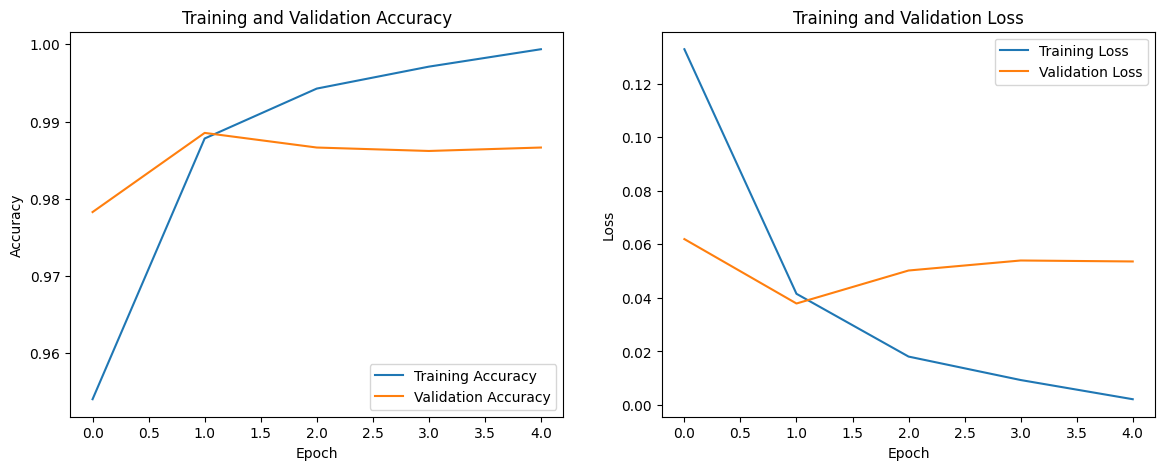

In [11]:
# ## 7. Performance Evaluation
# 학습 곡선 시각화
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

281/281 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step


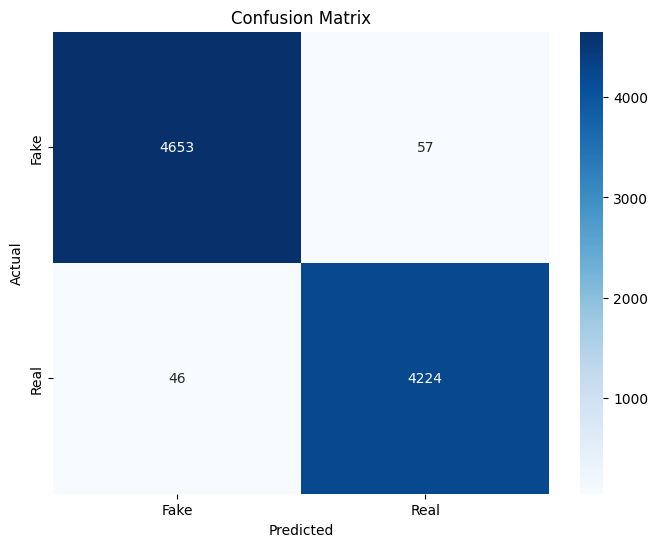

In [12]:
# 예측 및 평가
y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [13]:
# Classification Report
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))


Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4710
        Real       0.99      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

